Notebook for exploring properties of network generation models

In [1]:
from scipy.stats.distributions import expon, binom, norm, lognorm
import networkx as nx
import pandas as pd
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt
import sys; sys.path.append("../data/literature/parsers")
import torinanet as tn
from model import RandomGraphModel, PreferentialAttachmentModel, Distribution, SimulatedReactionGraph, KineticSolver

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


In [3]:
BASE_GRAPH_PATH = "../data/literature/$.rxn"
GRAPH_NAMES = ["ammonia", "hydrogen", "methane"]

# Reaction Energy Distribution

Enhance networks with their thermodynamic data. this contains the reaction energy based on atomization energy, enthalpy and gibbs free energy. first define a few helper functions

In [4]:
import torinanet as tn
from utils import NasaPolynomial
import json

def calculate_reaction_energy(rxn: tn.core.Reaction, specie_energy_func):
    """
    Add reaction energy based on atomization energy, species enthalpy and gibbs free energy. 
    """
    products_e = [specie_energy_func(s) for s in rxn.products]
    reactants_e = [specie_energy_func(s) for s in rxn.reactants]
    if None in products_e or None in reactants_e:
        return None
    return sum(products_e) - sum(reactants_e)

def _specie_enthalpy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature)

def _specie_entropy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.s(temperature)

def specie_entropy(temperature: float):
    return lambda sp: _specie_entropy(sp, temperature)

def specie_enthalpy(temperature: float):
    return lambda sp: _specie_enthalpy(sp, temperature)

def _specie_free_energy(sp: tn.core.Specie, temperature: float):
    if not "thermo" in sp.properties:
        return None
    s = sp.properties["thermo"].replace("'", "\"")
    d = json.loads(s)
    poly = NasaPolynomial(**d)
    return poly.h(temperature) - temperature * poly.s(temperature)

def specie_free_energy(temperature: float):
    return lambda sp: _specie_free_energy(sp, temperature)

def add_reaction_energies(rxn_graph: tn.core.RxnGraph, specie_energy_funcs: dict):
    """
    Add reaction energies to the reaction graph.
    """
    for rxn in rxn_graph.reactions:
        for name, func in specie_energy_funcs.items():
            e = calculate_reaction_energy(rxn, func)
            if e is not None:
                rxn.properties[name] = e
    return rxn_graph

def estimate_reaction_kinetics(rxn_graph: tn.core.RxnGraph, default_temperature: float=600):
    """
    Estimate reaction rate parameters
    """
    for rxn in rxn_graph.reactions:
        if not pd.isna(rxn.properties.get("rEa", pd.NA)) and \
            not pd.isna(rxn.properties.get("rA", pd.NA)) and \
            not pd.isna(rxn.properties.get("rbeta", pd.NA)):
            h = calculate_reaction_energy(rxn, specie_enthalpy(default_temperature))
            s = calculate_reaction_energy(rxn, specie_entropy(default_temperature))
            dn = calculate_reaction_energy(rxn, lambda s: 1)
            if h is None or s is None:
                continue
            # note that we calculate using the reverse reaction h and s, so we need to negate them
            rxn.properties["Ea"] = h + rxn.properties["rEa"] * 4.184
            rxn.properties["A"] = rxn.properties["rA"] * np.exp(s / 8.314) * 1 / 8.314 ** dn
            rxn.properties["beta"] = rxn.properties["rbeta"] + dn
        elif not pd.isna(rxn.properties.get("Ea", pd.NA)):
            # fix Ea to be in J/mol
            rxn.properties["Ea"] = rxn.properties["Ea"] * 4.184
    return rxn_graph

def rxn_properties_to_df(rxn_graph: tn.core.RxnGraph, properties: list):
    """
    Convert reaction properties to a pandas DataFrame.
    """
    data = []
    idx = []
    for rxn in rxn_graph.reactions:
        row = {prop: rxn.properties.get(prop, None) for prop in properties}
        idx.append(rxn_graph.reaction_collection.get_key(rxn))
        data.append(row)
    return pd.DataFrame(data, index=idx)

def graph_properties_df(g: tn.core.RxnGraph):
    funcs = {}
    for t in [300, 600, 900, 1200]:
        funcs[f"enthalpy_{t}"] = specie_enthalpy(t)
        funcs[f"free_energy_{t}"] = specie_free_energy(t)
    funcs["atomization_energy"] = lambda sp: - sp.properties["atomization_energy"] if "atomization_energy" in sp.properties else None
    g = add_reaction_energies(g, funcs)
    g = estimate_reaction_kinetics(g)
    return rxn_properties_to_df(g, list(funcs.keys()) + ["Ea", "A", "beta", "rEa", "rA", "rbeta"])

## temperature dependence of the thermo properties

In [161]:
df = pd.DataFrame()
for path in GRAPH_NAMES:
    g = tn.core.RxnGraph.from_file(BASE_GRAPH_PATH.replace("$", path))
    ajr = graph_properties_df(g)
    ajr["graph"] = path
    ajr.index = [path + "." + x for x in ajr.index]
    df = pd.concat([df, ajr])
df

,enthalpy_300,free_energy_300,enthalpy_600,free_energy_600,enthalpy_900,free_energy_900,enthalpy_1200,free_energy_1200,atomization_energy,Ea,A,beta,rEa,rA,rbeta,graph
ammonia.N2O+OH->NH+NO2,270272.440524,264982.623767,269538.320151,259980.208609,268992.984593,255323.620537,268474.077372,250844.395078,NaN,260040.640151,5.876973e+11,0.0,-2270.0,8.650000e+10,0.0,ammonia
ammonia.N2O->N2+O,167596.976227,127776.791542,169623.219798,86944.592836,169817.740235,45517.874349,169279.643126,4153.761622,NaN,262002.080000,1.260000e+12,0.0,NaN,NaN,NaN,ammonia
ammonia.H+NO->N+OH,202758.453619,199285.656742,202537.981046,195856.218915,201769.526814,192662.825005,200806.655466,189773.845688,NaN,202537.981046,1.068755e+14,0.0,0.0,2.800000e+13,0.0,ammonia
ammonia.N+NO2->NO+NO,-324329.908317,-332739.920514,-324975.514394,-341056.739077,-326609.221986,-348754.707886,-328333.316553,-355876.635813,NaN,0.000000,1.000000e+12,0.0,NaN,NaN,NaN,ammonia
ammonia.NNH+NO->HNO+N2,-233676.382430,-226855.722925,-234347.106124,-219808.299408,-235084.104066,-212367.745370,-235413.658691,-204730.057438,NaN,0.000000,5.000000e+13,0.0,NaN,NaN,NaN,ammonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
methane.CH3OH+H->CH2OH+H2,-31663.207605,-37707.710894,-28852.977128,-45026.943527,-28424.040007,-53278.871348,-29377.554552,-61450.223482,0.454968,20376.080000,1.700000e+07,2.1,NaN,NaN,NaN,methane
methane.CH+CO->HCCO,-309412.633836,-269197.579185,-310378.263942,-228345.557988,-309509.183431,-187484.133958,-308230.616836,-146998.938275,NaN,0.000000,5.000000e+13,0.0,NaN,NaN,NaN,methane
methane.C3H7->C2H4+CH3,98917.598604,61739.268561,99858.429925,23931.410243,98635.947767,-13829.808499,96722.599944,-51026.993551,NaN,123707.229925,1.250268e+12,2.6,5700.0,2.550000e+06,1.6,methane
methane.CH2CO+H->C2H3+O,378599.968977,367110.639821,376223.206131,356570.823931,374399.652894,347153.660601,372998.772420,338296.690333,NaN,376223.206131,1.541966e+15,0.0,0.0,3.000000e+13,0.0,methane


enthalpy 300 -1660.9573751905602 264196.6704049077
enthalpy 600 -1620.5969455106363 265229.32907759154
enthalpy 900 -1611.10327593923 266107.16813358106
enthalpy 1200 -1615.6366237406864 266816.50529698504
free_energy 300 -2124.528290754634 256231.35626089165
free_energy 600 -2607.0310216395483 248983.3847258654
free_energy 900 -3103.1257402086253 242515.60590605452
free_energy 1200 -3600.016394853218 237147.68854907353
atomization_energy 314


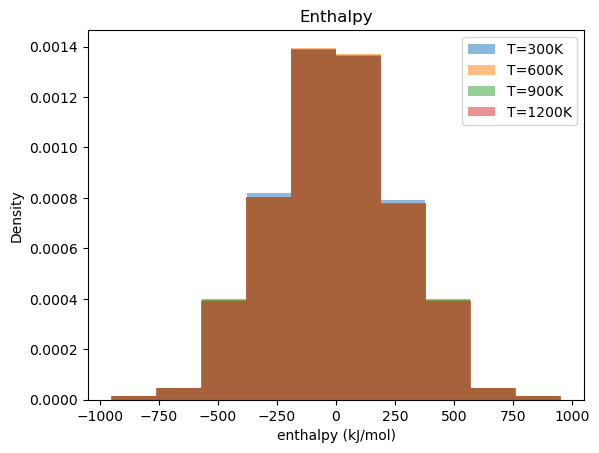

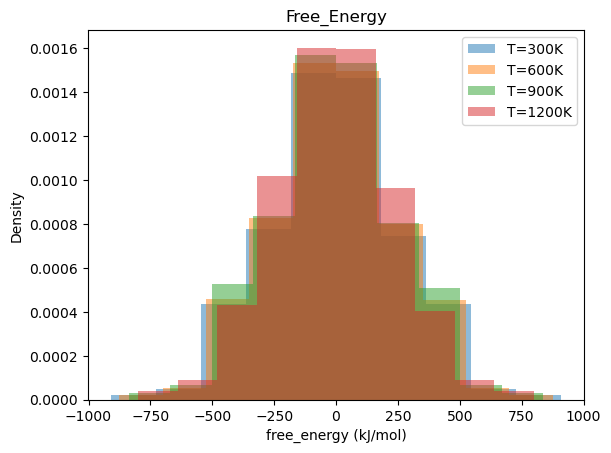

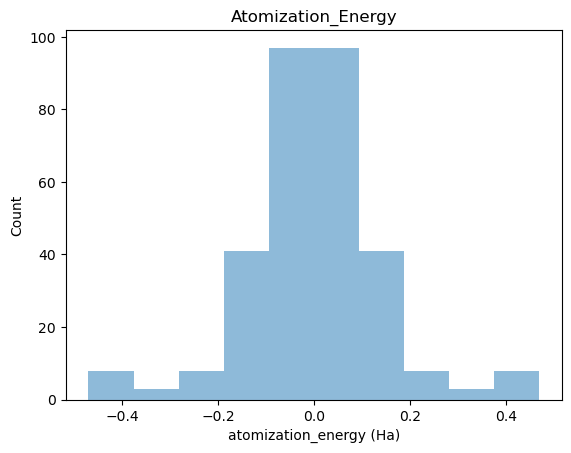

In [162]:
for p in ["enthalpy", "free_energy", "atomization_energy"]:
    plt.figure()
    if p == "atomization_energy":
        plt.hist(df[p].dropna(), alpha=0.5)
        plt.xlabel(f"{p} (Ha)")
        plt.ylabel("Count")
        print(p, len(df[p].dropna()))
    else:
        for t in [300, 600, 900, 1200]:
            plt.hist(df[f"{p}_{t}"].dropna() / 1000, density=True, alpha=0.5, label=f"T={t}K")
            values = df[f"{p}_{t}"].dropna()
            print(p, t, np.mean(values), np.std(values))
        plt.legend()
        plt.xlabel(f"{p} (kJ/mol)")
        plt.ylabel("Density")
    plt.title(f"{p.title()}")

## Specie energy distribution

In [163]:
import sqlite3
from openbabel import openbabel as ob
import pandas as pd

connection = sqlite3.connect("../data/joined.db")

def get_energy(smiles):
    return connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()[0][0]

def get_atomization_energy(smiles: str, atom_energies: dict):
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    return ajr - get_energy(smiles)


atom_energies = {"H": get_energy("[H]"), "N": get_energy("[N]"), "O": get_energy("[O]"), "C": get_energy("[C]")}
# get_atomization_energy("N[N]", atom_energies)
smiles_strings = connection.execute("SELECT smiles FROM species WHERE successful=1").fetchall()
atomization_energies = [get_atomization_energy(smiles[0], atom_energies) for smiles in smiles_strings]
atomization_energies_df = pd.DataFrame({"smiles": [s[0] for s in smiles_strings], "energy": atomization_energies})

connection.close()

In [164]:
atomization_energies_df["energy"].describe()

count    4275.000000
mean        0.407644
std         0.332978
min        -0.154391
25%         0.211851
50%         0.317106
75%         0.465889
max         1.949357
Name: energy, dtype: float64

(array([3.03122152e-04, 6.06244304e-04, 9.09366456e-04, 2.12185506e-03,
        6.66868734e-03, 2.54622608e-02, 2.14913606e-01, 6.30190954e-01,
        2.71900570e-01, 1.28826915e-01]),
 array([-7.13339933, -6.35330945, -5.57321958, -4.79312971, -4.01303984,
        -3.23294997, -2.45286009, -1.67277022, -0.89268035, -0.11259048,
         0.66749939]),
 <BarContainer object of 10 artists>)

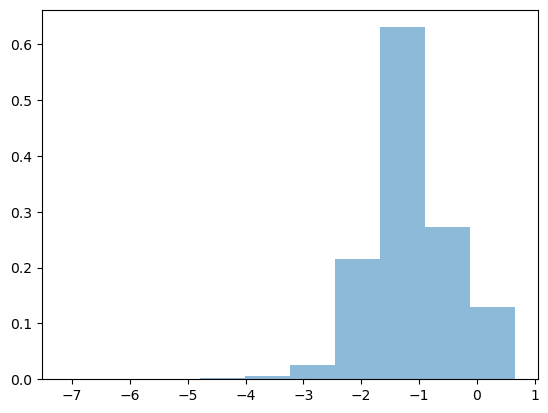

In [165]:
plt.hist([np.log(a) for a in atomization_energies if a > 0], density=True, alpha=0.5)
# plt.hist(atomization_energies_df[~atomization_energies_df["smiles"].str.contains("C")]["energy"], density=True, alpha=0.5)

Mean: -1.1462845950442835 Std: 0.7371980554642066 N: 4229


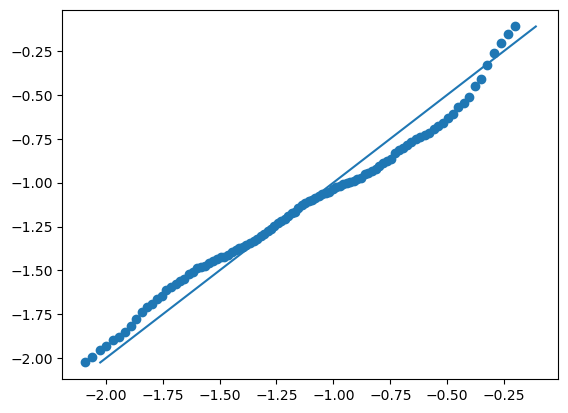

In [166]:
log_energies = [np.log(a) for a in atomization_energies if a > 0]
m = np.mean(log_energies)
s = np.std(log_energies)
dist = norm(m, s)
quantiles = np.linspace(10, 90, 100)
true = np.percentile(log_energies, quantiles)
pred = [dist.ppf(x / 100) for x in quantiles]
plt.figure();
plt.scatter(pred, true);
plt.plot(true, true);
print("Mean:", m, "Std:", s, "N:", len(log_energies))

In [167]:
from scipy import stats
base_path = "../data/literature/$.rxn"
graphs_paths = ["ammonia", "hydrogen", "methane"]
base_mean = np.mean(log_energies)
base_std = np.std(log_energies)
data = []
for path in graphs_paths:
    g = tn.core.RxnGraph.from_file(base_path.replace("$", path))
    sp_energies = [sp.properties.get("atomization_energy", None) for sp in g.species]
    log_sp_energies = [np.log(- e) for e in sp_energies if (e is not None) and (e < 0)]
    # Perform a two-sample t-test to compare the populations
    t_stat, p_value = stats.ttest_ind(log_sp_energies, log_energies, equal_var=False)    
    data.append({"graph": path, "mean": np.mean(log_sp_energies), "std": np.std(log_sp_energies), "n_species": g.get_n_species(), "pvalue": p_value})
df = pd.DataFrame(data)
df

,graph,mean,std,n_species,pvalue
0,ammonia,-1.809859,0.554744,30,0.000202
1,hydrogen,-2.025261,0.525785,12,0.028664
2,methane,-1.171404,0.873793,34,0.919109


# Kinetic scaling relations
now we try to check out the scaling relations between reaction energy and max reaction rate

In [168]:
base_path = "../data/literature/$.rxn"
graphs_paths = ["ammonia", "hydrogen", "methane"]
df = pd.DataFrame()
for path in graphs_paths:
    g = tn.core.RxnGraph.from_file(base_path.replace("$", path))
    g = estimate_reaction_kinetics(g)
    g = add_reaction_energies(g, {
            "deltaE": lambda sp: - sp.properties["atomization_energy"] if "atomization_energy" in sp.properties else None,
            "H": specie_enthalpy(600),
            "S": specie_entropy(600)
        }
    )
    ajr = rxn_properties_to_df(g, ["Ea", "A", "beta", "deltaE", "rEa", "rA", "rbeta", "H", "S"])
    ajr["graph"] = path
    ajr.index = [path + "." + x for x in ajr.index]
    df = pd.concat([df, ajr])
# df = df.dropna(subset=["Ea", "deltaE"])
df["deltaE"] = - df["deltaE"] # the sign is inverted in the atomization energy calculations, so we correct for it

In [169]:
# gather kinetic and thermodynamic data
from scipy import stats
print("N REACTIONS", len(df))

# add log k column
R = 8.314 # j / K mol
kb = 1.38e-23 # J / K
h = 6.626e-34 # J s
ha_to_J = 4.360e-18 # J / Ha
cal_to_J = 4.184 # J / cal

def calculate_rate_constants(df, T):
    ajr = df.copy()
    ajr["logk_arrhenius"] = np.log(ajr["A"]) + ajr["beta"] * np.log(T) - cal_to_J * ajr["Ea"] / (R * T)
    ajr["logk_eyring"] = np.log(kb / h) + np.log(T) - ha_to_J * ajr["deltaE"] / (kb * T)
    return ajr        

def summary_fit(df):
    data = []
    for col in df.columns:
        if col not in ["T", "1/T"]:
            a,b = np.polyfit(ajr["1/T"], ajr[col], deg=1)
            r2 = stats.pearsonr(ajr["1/T"], ajr[col]).statistic ** 2
            data.append([col, a, b, r2])
    return pd.DataFrame(data, columns=["property", "slope", "intecept", "r2"])


N REACTIONS 1008


log(A) 28.66168969574889 11.616526721145696 1008
log(Ea) (kJ/mol) 9.227015222065473 1.400959654850494 252
beta 0.32025853174603175 1.2346915613196179 1008


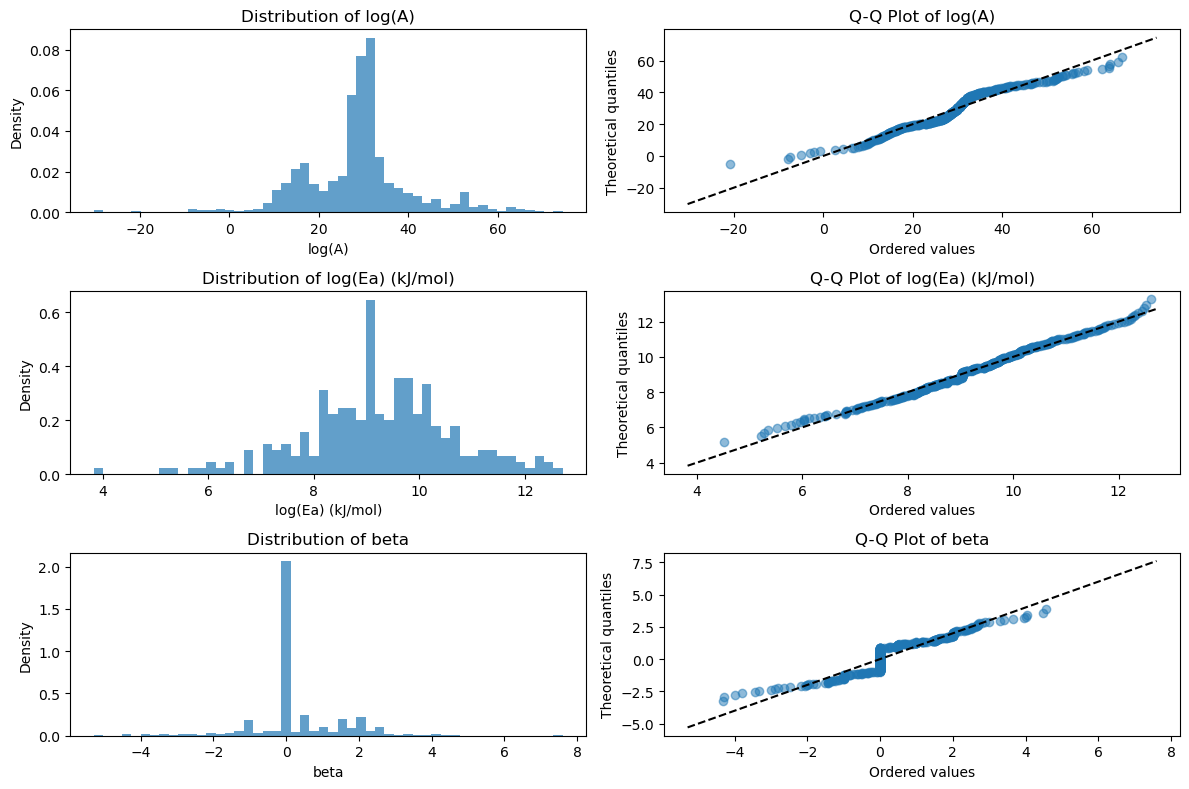

In [170]:
# checkout the distributions for each kinetic property - Ea, A, beta

properties = {
    "A": {"name": "log(A)", "transform": np.log, "filter": False},
    "Ea": {"name": "log(Ea) (kJ/mol)", "transform": np.log, "filter": True},
    "beta": {"name": "beta", "transform": lambda x: x, "filter": False}
}

fig, axs = plt.subplots(3, 2, figsize=(12, 8))
for i, prop in enumerate(properties):
    if properties[prop]["filter"]:
        values = df[(df["H"] < 0) & (df[prop] > 0)][prop].dropna()
    else:
        values = df[prop].dropna()
    transformed_data = properties[prop]["transform"](values)
    axs[i, 0].hist(transformed_data, bins=50, density=True, alpha=0.7)
    axs[i, 0].set_title(f"Distribution of {properties[prop]['name']}")
    axs[i, 0].set_xlabel(properties[prop]["name"])
    axs[i, 0].set_ylabel("Density")

    dist = norm(np.mean(transformed_data), np.std(transformed_data))
    q = np.linspace(0, 100, 500)
    axs[i, 1].scatter(np.percentile(transformed_data, q), dist.ppf(q / 100), alpha=0.5)
    axs[i, 1].plot(np.percentile(transformed_data, q), np.percentile(transformed_data, q), color="k", linestyle="--")
    axs[i, 1].set_xlabel("Ordered values")
    axs[i, 1].set_ylabel("Theoretical quantiles")
    axs[i, 1].set_title(f"Q-Q Plot of {properties[prop]['name']}")
    print(properties[prop]["name"], np.mean(transformed_data), np.std(transformed_data), len(transformed_data))
plt.tight_layout()

Slope 9.54e-01 Intercept 2.02e+04 Error mean 5.09e-11 Error STD 3.55e+04 R^2 0.95


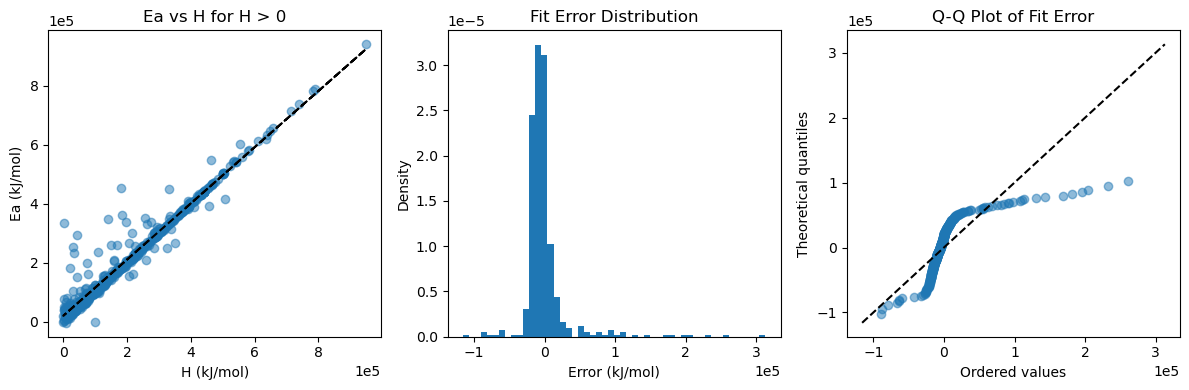

In [171]:
# now check the situation for Ea when H > 0

fig, axs = plt.subplots(ncols=3, figsize=(12, 4))
for ax in axs:
    ax.ticklabel_format(style='scientific', axis='both', scilimits=(0, 0))
ajr = df[df["H"] > 0]
# scatter plot
axs[0].scatter(ajr["H"], ajr["Ea"], alpha=0.5)
a, b = np.polyfit(ajr["H"], ajr["Ea"], deg=1)
pred = a * ajr["H"] + b
axs[0].plot(ajr["H"], pred, color="k", linestyle="--");
axs[0].set_xlabel("H (kJ/mol)")
axs[0].set_ylabel("Ea (kJ/mol)")
axs[0].set_title("Ea vs H for H > 0")
# error distribution 
r = ajr["Ea"] - pred
axs[1].hist(r, bins=50, density=True);
q = np.linspace(0, 100, 500)
print("Slope", f"{a:.2e}", "Intercept", f"{b:.2e}", "Error mean", f"{np.mean(r):.2e}", "Error STD", f"{np.std(r):.2e}", "R^2", f"{stats.pearsonr(ajr['H'], ajr['Ea']).statistic ** 2:.2f}")
axs[1].set_xlabel("Error (kJ/mol)")
axs[1].set_ylabel("Density")
axs[1].set_title("Fit Error Distribution")
# q-q plot for error vs normal distribution
axs[2].scatter(np.percentile(r, q), norm(np.mean(r), np.std(r)).ppf(q / 100), alpha=0.5);
axs[2].plot(np.percentile(r, q), np.percentile(r, q), color="k", linestyle="--");
axs[2].set_xlabel("Ordered values")
axs[2].set_ylabel("Theoretical quantiles")
axs[2].set_title("Q-Q Plot of Fit Error")
plt.tight_layout()


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


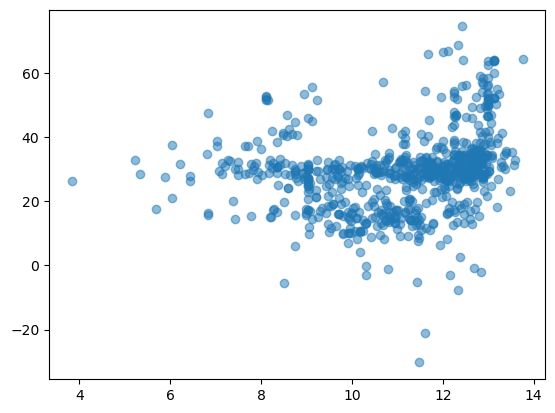

In [172]:
plt.scatter(np.log(df["Ea"]), np.log(df["A"]), alpha=0.5)
# plt.ylim(df["A"].min(), df["A"].nlargest(100).iloc[-1])

# Compare network properties
Proof goodness of fit of pereferential attachement model by comparing it to known networks

In [7]:
from typing import Union

class LogNormal:

    def __init__(self, mean: float, std: float):
        self.mean = mean
        self.std = std
        self.dist = norm(mean, std)

    def rvs(self):
        return np.exp(self.dist.rvs())

def generate_activation_energy(rxn_energy: float):
    if rxn_energy < 0:
        return LogNormal(9.23, 1.40).rvs()
    else:
        base_value = 9.54e-1 * rxn_energy + 2.02e4 # prediction from fitted values
        error = norm(0, 3.55e4).rvs() # error from fitted values
        return base_value + error

def generate_synthetic_graphs(nspeices, nreactions, ngraphs):
    # make the base model
    model = PreferentialAttachmentModel(
        nspeices, 
        nreactions, 
        specie_energy_dist=norm(-1620.6, 265229.3)
    )
    # make generators for the kinetic properties
    A = LogNormal(28.66, 11.62)
    beta = norm(0.32, 1.23)
    res = []
    for _ in range(ngraphs):
        g = model.generate_graph()
        # add kinetic properties
        for rxn in g.reactions():
            rxn.properties["Ea"] = generate_activation_energy(rxn.properties["energy"])
            rxn.properties["A"] = A.rvs()
            rxn.properties["beta"] = beta.rvs()
        res.append(g)
    return res

class DegreeTypes (Enum):
    IN = 0
    OUT = 1
    TOTAL = 2

def get_degrees(rxn_graph: Union[tn.core.RxnGraph, SimulatedReactionGraph]) -> pd.DataFrame:
    if isinstance(rxn_graph, tn.core.RxnGraph):
        g = rxn_graph.to_networkx_graph(use_internal_id=True)
        species = set(rxn_graph.specie_collection.keys())
        typer = lambda node: "s" if node in species else "r"
    else:
        g = rxn_graph.g
        typer = lambda node: "r" if "r" in node else "s"
    data = []
    for node in g.nodes:
        if node == "s0":
            continue
        ajr = {
            "type": typer(node),
            "in": len([x for x in g.predecessors(node) if not x == "s0"]),
            "out": len([x for x in g.successors(node) if not x == "s0"]),
            "total": len([x for x in g.predecessors(node) if not x == "s0"]) + len([x for x in g.successors(node) if not x == "s0"]),
        }
        data.append(ajr)
    return pd.DataFrame(data, index=[s for s in g.nodes if s != "s0"])

In [12]:
# collect data

# published netwoks
# data = {}
# for gname in GRAPH_NAMES:
#     data[gname] = {}
#     rxngraph = tn.core.RxnGraph.from_file(BASE_GRAPH_PATH.replace("$", gname))
#     rxngraph = estimate_reaction_kinetics(rxngraph)
#     data[gname]["real"] = rxngraph
#     data[gname]["simulated"] = generate_synthetic_graphs(rxngraph.get_n_species(), rxngraph.get_n_reactions(), 10)


# collect data - enmerated networks
data = {}
base_paths = {
    "hydrogen": "../data/enumerated/raw/hydrogen/rxn_graph.rxn",
    "ammonia": "../data/enumerated/raw/ammonia/2/crud_graph.rxn",
}
for gname in ["hydrogen", "ammonia"]:
    data[gname] = {}
    rxngraph = tn.core.RxnGraph.from_file(base_paths[gname])
    # rxngraph = estimate_reaction_kinetics(rxngraph)
    print(f"Graph {gname} has {rxngraph.get_n_species()} species and {rxngraph.get_n_reactions()} reactions")
    data[gname]["real"] = rxngraph
    data[gname]["simulated"] = generate_synthetic_graphs(rxngraph.get_n_species(), rxngraph.get_n_reactions(), 10)

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


Graph hydrogen has 12 species and 182 reactions


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


Graph ammonia has 89 species and 1442 reactions


compare degree distributions

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


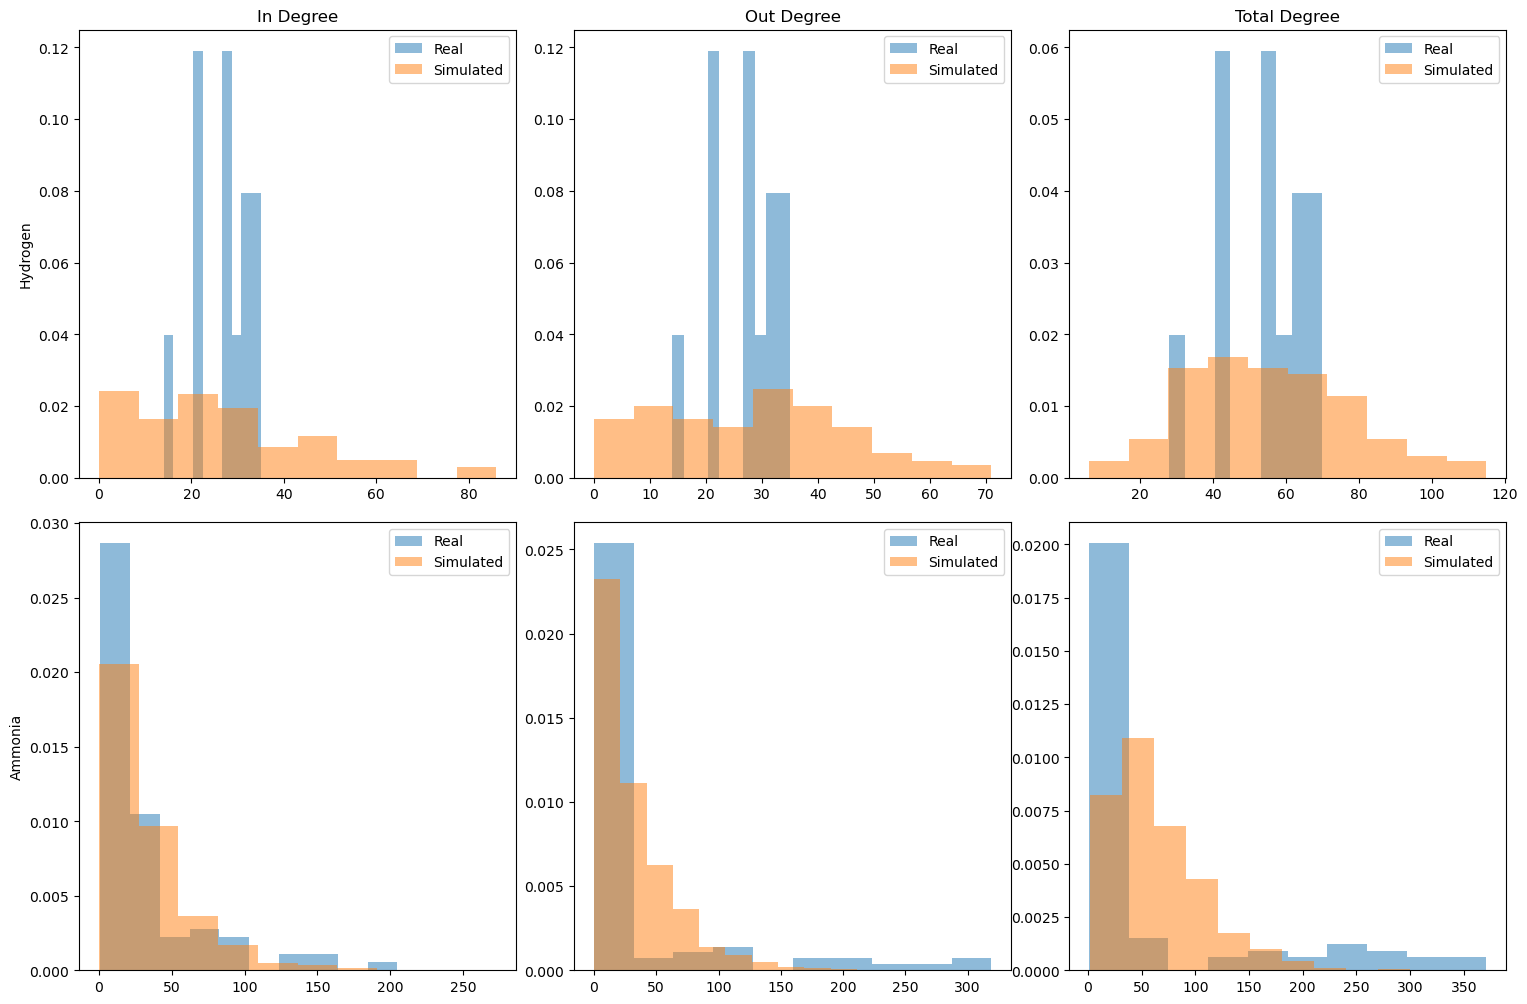

In [13]:
# compare specie degree distributions between real and simulated graphs
fig, axs = plt.subplots(nrows=len(data), ncols=3, figsize=(15, 5 * len(data)))
plt.tight_layout()
i = 0
for gname, nets in data.items():
    real_degrees = get_degrees(nets["real"])
    simulated_degrees = pd.concat([get_degrees(g) for g in nets["simulated"]])

    # filter out only specie degrees
    real_degrees = real_degrees[real_degrees["type"] == "s"]
    simulated_degrees = simulated_degrees[simulated_degrees["type"] == "s"]
    j = 0
    for degree_type in real_degrees.columns:
        if degree_type == "type":
            continue
        axs[i, j].hist(real_degrees[degree_type], alpha=0.5, label=f"Real", density=True)
        axs[i, j].hist(simulated_degrees[degree_type], alpha=0.5, label=f"Simulated", density=True)
        axs[i, j].legend()
        if i == 0:
            axs[i, j].set_title(f"{degree_type.title()} Degree")
        if j == 0:
            axs[i, j].set_ylabel(f"{gname.title()}")
        j += 1
    i += 1


/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')
/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


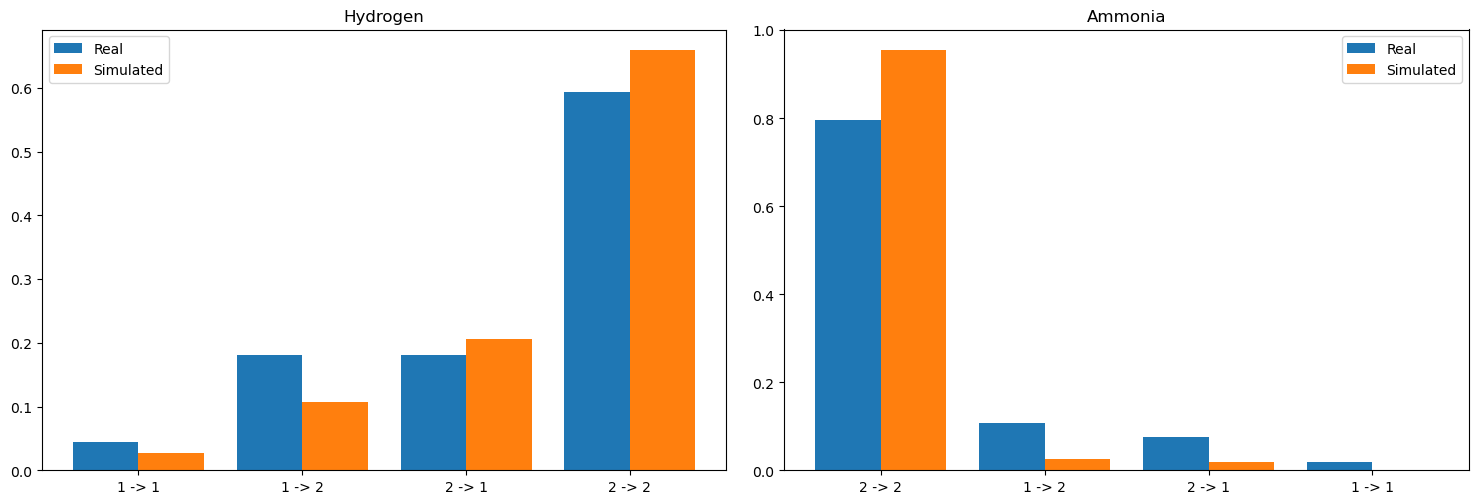

In [16]:
# compare specie degree distributions between real and simulated graphs
fig, axs = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))
plt.tight_layout()
i = 0
for gname, nets in data.items():
    real_degrees = get_degrees(nets["real"])
    simulated_degrees = pd.concat([get_degrees(g) for g in nets["simulated"]])

    # filter out only specie degrees
    real_degrees = real_degrees[real_degrees["type"] == "r"]
    simulated_degrees = simulated_degrees[simulated_degrees["type"] == "r"]

    # add reaction type as str
    real_degrees["rxn"] = ["{} -> {}".format(r["in"], r["out"]) for r in real_degrees.to_dict("records")]
    simulated_degrees["rxn"] = ["{} -> {}".format(r["in"], r["out"]) for r in simulated_degrees.to_dict("records")]

    real = real_degrees["rxn"].value_counts() / len(real_degrees)
    simulated = simulated_degrees["rxn"].value_counts() / len(simulated_degrees)
    df = real.to_frame().merge(simulated, how="outer", left_index=True, right_index=True, suffixes=("_real", "_simulated"))
    ticks = np.arange(len(df.index))
    axs[i].bar(ticks - 0.2, df["count_real"], label=f"Real", width=0.4, align='center')
    axs[i].bar(ticks + 0.2, df["count_simulated"], label=f"Simulated", width=0.4, align='center')
    axs[i].set_title(gname.title())
    axs[i].set_xticks(ticks, df.index)
    axs[i].legend()
    i += 1

Compare energy distribution

In [21]:
# add energy data to enumerated graphs
import sqlite3
from openbabel import openbabel as ob

def get_energy(connection, smiles):
    l = connection.execute("SELECT energy FROM species WHERE smiles=\"{}\"".format(smiles)).fetchall()
    if len(l) > 0:
        return l[0][0]
    else:
        return None

def get_atomization_energy(connection, smiles: str, atom_energies: dict):
    if smiles is None:
        return None
    # read smiles
    conv = ob.OBConversion()
    conv.SetInFormat("smi")
    obmol = ob.OBMol()
    conv.ReadString(obmol, smiles)
    obmol.AddHydrogens()
    # get single atom energy
    ajr = 0
    for atom in ob.OBMolAtomIter(obmol):
        ajr += atom_energies[ob.GetSymbol(atom.GetAtomicNum())]
    e = get_energy(connection, smiles)
    if e is not None:
        return e - ajr
    else:
        return None

def add_atomization_energies(db_path, rxn_graph) -> tn.core.RxnGraph:
    """Method to update the species energies in the reaction graph from the computation"""
    connection = sqlite3.connect(db_path)
    atom_energies = {
                     "H": get_energy(connection, "[H]"), 
                     "O": get_energy(connection, "[O]"), 
                     "C": get_energy(connection, "[C]"),
                     "N": get_energy(connection, "[N]")
                    }
    for specie in rxn_graph.species:
        smiles = specie.identifier 
        atomization_energy = get_atomization_energy(connection, smiles, atom_energies)
        if atomization_energy is not None:
            specie.properties["atomization_energy"] = atomization_energy
    return rxn_graph

db_path = "../data/joined.db"
data["ammonia"]["real"] = add_atomization_energies(db_path, data["ammonia"]["real"])
data["hydrogen"]["real"] = add_atomization_energies(db_path, data["hydrogen"]["real"])

/home/shachar/miniconda3/envs/pymatgen/lib/python3.11/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


[147155.2413550886, 342291.0483763207, 435829.65068116714, 193148.61477425217, -69865.4420120496, -147712.04190726765, 211353.6480942879, 281219.0901063375, 263014.0567863018, -77846.59989521804] [-193795.1664513589, 343737.0062586898, 46899.23649367085, 338713.78154771833, 460032.40226553474, 434306.4553042335, 220168.83656220563, -353602.46471599606, 160525.13643664017, 230871.22586165037]
1.6630760260990687e-12 -22983.18719506085
[346693.0763240235, 276558.4044466084, 147155.2413550886, -613791.8542996112, 424853.55469695246, 197550.64272195497, 157984.36582680186, 386097.2912227422, 443959.5754355171, 206692.96243455866] [-163658.05889893352, 48889.83105345507, -172696.8606061968, -802059.656475778, -360673.6053840694, -360600.41310988885, 336730.8275690562, 221312.61484342354, 109443.04788892501, 288138.5870969562]
-55994.85281568941 -10990.956966298832


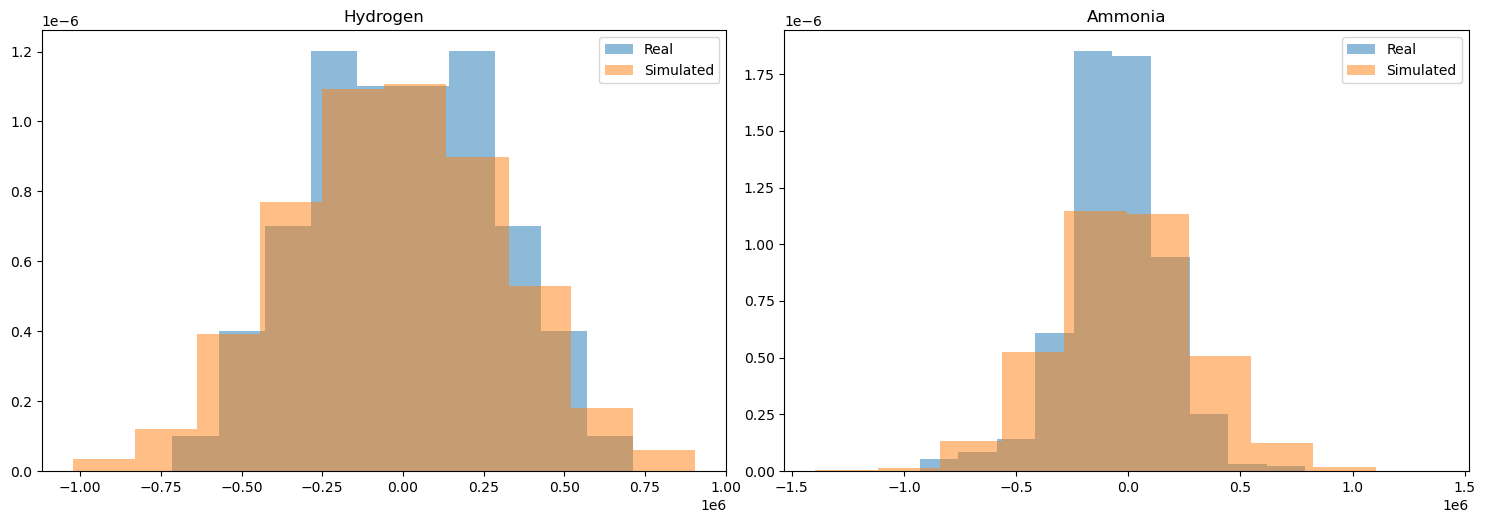

In [ ]:
def get_reaction_energies(rxn_graph: Union[tn.core.RxnGraph, SimulatedReactionGraph]) -> pd.DataFrame:
    if isinstance(rxn_graph, tn.core.RxnGraph):
        g = rxn_graph.to_networkx_graph(use_internal_id=True)
        rxns = rxn_graph.reaction_collection.keys()
        # energy_func = lambda node: specie_enthalpy(600)(g.nodes[node]["obj"]) # for published networks
        energy_func = lambda node: g.nodes[node]["obj"].properties["atomization_energy"] * 2625.5e3 if "atomization_energy" in g.nodes[node]["obj"].properties else None # convert Ha to J/mol, enumerated networks
    else:
        g = rxn_graph.g
        rxns = rxn_graph.get_reactions()
        energy_func = lambda node: g.nodes[node].get("energy", None)
    data = []
    for rxn in rxns:
        products_e = [energy_func(s) for s in g.successors(rxn)]
        reactants_e = [energy_func(s) for s in g.predecessors(rxn)]
        if None in products_e or None in reactants_e:
            continue
        ajr  = sum(products_e) - sum(reactants_e)
        data.append(ajr)
    return data

fig, axs = plt.subplots(nrows=1, ncols=len(data), figsize=(15, 5))
plt.tight_layout()
i = 0
for gname, nets in data.items():
    real_e = get_reaction_energies(nets["real"])
    simulated_e = []
    for g in nets["simulated"]:
        simulated_e.extend(get_reaction_energies(g))
    print(np.mean(real_e), np.mean(simulated_e))
    axs[i].plot()
    axs[i].hist(real_e, label=f"Real", alpha=0.5, density=True)
    axs[i].hist(simulated_e, label=f"Simulated", alpha=0.5, density=True)
    axs[i].set_title(gname.title())
    axs[i].legend()
    # tstat, pvalue = stats.ttest_ind(real_e, simulated_e, equal_var=False)
    # print(gname, pvalue, len(simulated_e))
    i += 1

compare rate constants

Text(150.09722222222223, 0.5, 'Density')

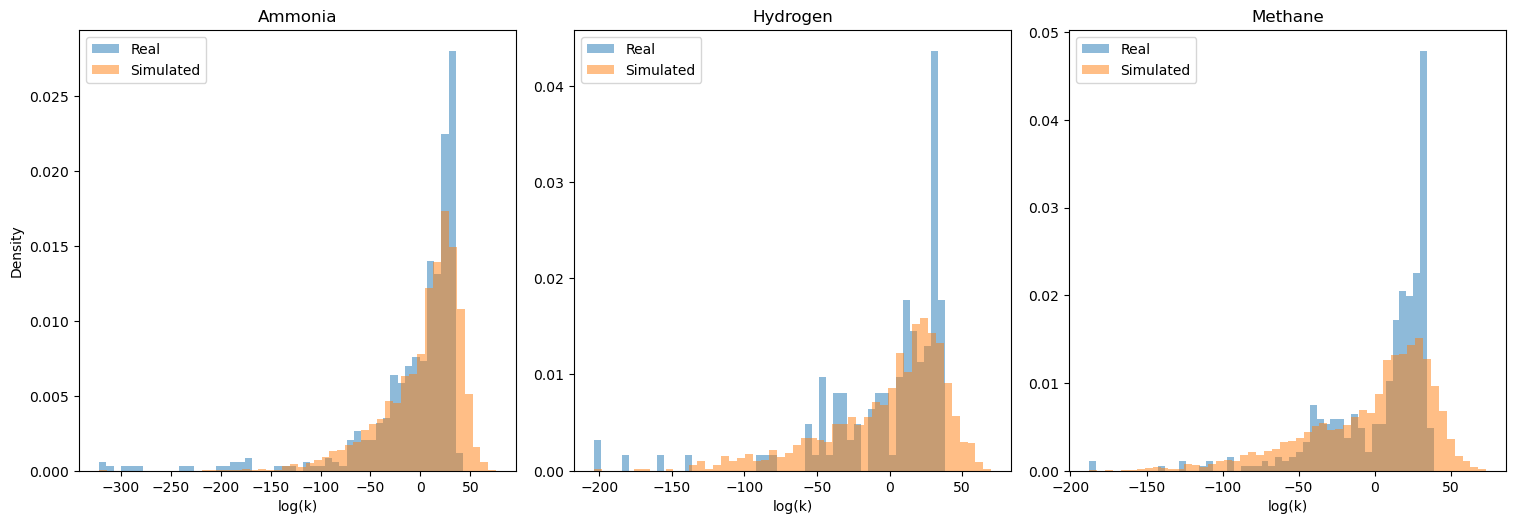

In [ ]:
def calc_k(g: nx.DiGraph, node: str):
    """
    Calculate the rate constant for a reaction based on its energy.
    """
    if "obj" in g.nodes[node]:
        props = g.nodes[node]["obj"].properties
    else:
        props = g.nodes[node]
    if any([pd.isna(props[x]) for x in ["Ea", "A", "beta"]]):
        return None
    T = 600  # K
    R = 8.314  # J / K mol
    # Calculate the rate constant using the Arrhenius equation
    k = np.log(props["A"]) + props["beta"] * np.log(T) - props["Ea"] / (R * T)
    return k

def get_properties(rxn_graph: Union[tn.core.RxnGraph, SimulatedReactionGraph], prop: str) -> pd.DataFrame:
    if isinstance(rxn_graph, tn.core.RxnGraph):
        rxn_graph = estimate_reaction_kinetics(rxn_graph)
        g = rxn_graph.to_networkx_graph(use_internal_id=True)
        rxns = rxn_graph.reaction_collection.keys()
    else:
        g = rxn_graph.g
        rxns = rxn_graph.get_reactions()
    if prop == "k":
        func = lambda node: calc_k(g, node)
    else:
        func = lambda node: g.nodes[node]["obj"].properties.get(prop, None) if "obj" in g.nodes[node] else g.nodes[node].get(prop, None)
    data = []
    for rxn in rxns:
        k = func(rxn)
        if k is None:
            continue
        data.append(k)
    return data

fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
plt.tight_layout()
i = 0
prope = "k"
for gname, nets in data.items():
    real_e = get_properties(nets["real"], prope)
    simulated_e = []
    for net in nets["simulated"]:
        simulated_e.extend(get_properties(net, prope))
    axs[i].hist(np.clip(real_e, min(simulated_e), max(simulated_e)), label=f"Real", alpha=0.5, bins=50, density=True)
    axs[i].hist(simulated_e, label=f"Simulated", alpha=0.5, bins=50, density=True)
    axs[i].set_title(gname.title())
    axs[i].legend()
    axs[i].set_xlabel("log(k)")
    i += 1
axs[0].set_ylabel("Density")

# Enumerated Network Kinetics

In [2]:
def solve_kinetics(g: SimulatedReactionGraph):
    solver = KineticSolver(g, "k")
    og = np.random.choice(g.get_species(), 2)
    iconcs = [1 if s in s in og else 0 for s in g.get_species()]
    step  = 1 / np.mean([rxn.properties["k"] for rxn in g.reactions()])
    solver.solve_kinetics(200 * step, step, iconcs)
    return solver

def add_rate_constants(g: SimulatedReactionGraph, temp: float):
    R = 8.314  # J / K mol
    for r in g.reactions():
        props = r.properties
        # Calculate the rate constant using the Arrhenius equation
        r.properties["k"] = props["A"] * np.power(temp, props["beta"]) * np.exp(- props["Ea"] / (R * temp))
    return g

def generate_network(n_species, n_reactions, sp_energy_dist, temperature):
    model = PreferentialAttachmentModel(n_species=n_species, 
                                            n_reactions=n_reactions, 
                                            specie_energy_dist=sp_energy_dist)
    g = model.generate_graph()
    g.add_kinetic_data()
    g = add_rate_constants(g, temperature)
    return g

def calculate_participation(g: SimulatedReactionGraph):
    participation = None
    for r in g.get_reactions():
        rate = np.array(g.get_properties(r)["rate"])
        p = np.where(rate > 0, 1, 0)
        if participation is None:
            participation = p
        else:
            participation += p
    return np.mean(participation) / len(g.get_reactions())

In [75]:
print("generating network")
g = generate_network(
    n_species=25, 
    n_reactions=1000, 
    sp_energy_dist=norm(-1620.6, 265229.3), 
    temperature=600
)

ks = np.array([rxn.properties["k"] for rxn in g.reactions()])
print("timestep", 1 / np.mean(ks))

print("solving kinetics")
solution = solve_kinetics(g)
concs = solution.concentrations_df()
rates = solution.get_rates()
participation = rates.applymap(lambda x: 1 if x > 0 else 0).sum(axis=0).mean() / len(rates)
print("avg reaction participation", participation)


generating network
timestep 7.266663673278152e-27
solving kinetics
avg reaction participation 0.7384626865671642


/tmp/ipykernel_582/2463526950.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  participation = rates.applymap(lambda x: 1 if x > 0 else 0).sum(axis=0).mean() / len(rates)


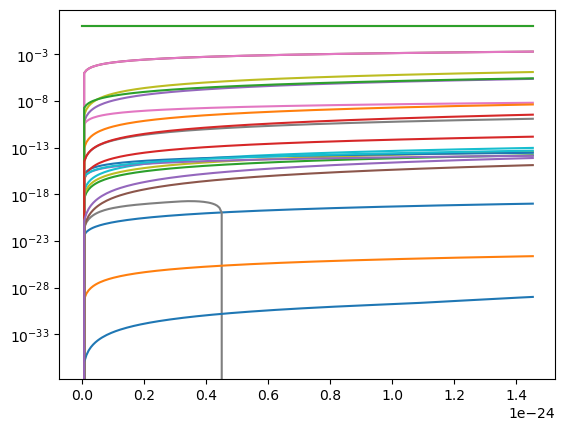

In [76]:
for c in concs.columns:
    plt.plot(concs.index, concs[c])
    plt.yscale('log')

# Graph Reduction Effects

## Random Percolation tests

In [80]:
def random_percolate_species(g: SimulatedReactionGraph, n: int):
    """Randomly remove n species from the graph"""
    ajr = g.copy()
    count = 0
    while count < n:
        if len(ajr.get_species()) == 0:
            return ajr
        sp = np.random.choice(ajr.get_species(), 1)[0]
        ajr.remove_specie(sp)
        count += 1
    return ajr

def random_percolate_reactions(g: SimulatedReactionGraph, n: int):
    """Randomly remove n reactions from the graph"""
    ajr = g.copy()
    count = 0
    while count < n:
        if len(ajr.get_reactions()) == 0:
            return ajr
        rxn = np.random.choice(ajr.get_reactions(), 1)[0]
        ajr.remove_reaction(rxn)
        count += 1
    return ajr

def solve_kinetics(g: SimulatedReactionGraph, origin_species):
    solver = KineticSolver(g, "k")
    iconcs = [1 if s in origin_species else 0 for s in g.get_species()]
    step  = 1 / np.mean([rxn.properties["k"] for rxn in g.reactions()])
    solver.solve_kinetics(200 * step, step, iconcs)
    return solver

In [136]:
og = generate_network(
    n_species=25, 
    n_reactions=1000, 
    sp_energy_dist=norm(-1620.6, 265229.3), 
    temperature=600
)

red = random_percolate_reactions(og, 300)

In [137]:
pd.DataFrame([[len(x.get_species()), len(x.get_reactions())] for x in [og, red]], columns=["nspecies", "nreactions"], index=["og", "red"])

,nspecies,nreactions
og,25,1000
red,25,700


In [138]:
original_sps = np.random.choice(red.get_species(), 2)
ogsolver = solve_kinetics(og, original_sps)
redsolver = solve_kinetics(red, original_sps)

In [139]:
participation = lambda df: df.applymap(lambda x: 1 if x > 0 else 0).sum(axis=0).mean() / len(df)

print("og participation", participation(ogsolver.get_rates()))
print("red participation", participation(redsolver.get_rates()))

/tmp/ipykernel_13504/580452770.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  participation = lambda df: df.applymap(lambda x: 1 if x > 0 else 0).sum(axis=0).mean() / len(df)


og participation 0.8764577114427861
red participation 0.917960199004975


/tmp/ipykernel_13504/580452770.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  participation = lambda df: df.applymap(lambda x: 1 if x > 0 else 0).sum(axis=0).mean() / len(df)


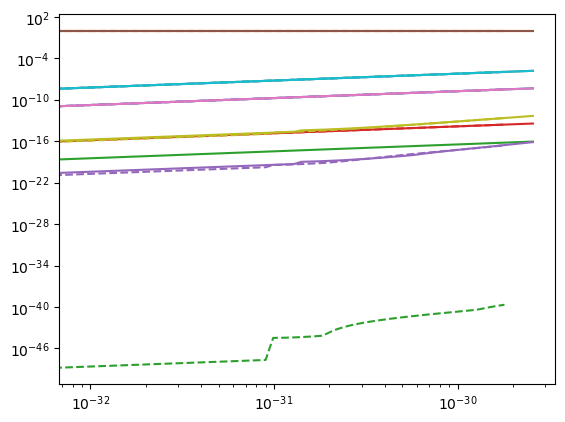

In [140]:
ogconcs = ogsolver.concentrations_df()
redconcs = redsolver.concentrations_df()
plotspeices = ogconcs.iloc[-1].nlargest(10).index
for sp in red.get_species():
    if sp in plotspeices:
        c = plt.gca()._get_lines.get_next_color()
        plt.plot(ogconcs.index, ogconcs[sp], label="og", color=c)
        plt.plot(redconcs.index, redconcs[sp], label="red", color=c, linestyle="--")
plt.xscale("log")
plt.yscale("log")


# OLD

In [2]:
from energy_reducer_effect import single_run, apply_energy_th
from model import KineticSolver
from scipy.stats.distributions import expon, binom, norm
import networkx as nx
import numpy as np
from enum import Enum
from matplotlib import pyplot as plt
import torinanet as tn
from model import RandomGraphModel, PreferentialAttachmentModel, Distribution, SimulatedReactionGraph

In [ ]:
def solve_kinetics(g: SimulatedReactionGraph):
    solver = KineticSolver(g, "k")
    g.set_origin()
    iconcs = [1 if s in s == g.origin else 0 for s in g.get_species()]
    step = 1e-13
    solver.solve_kinetics(100 * step, step, iconcs)
    return solver

def generate_network(n_species, n_reactions, sp_energy_dist, temperature):
    model = PreferentialAttachmentModel(n_species=n_species, 
                                            n_reactions=n_reactions, 
                                            specie_energy_dist=sp_energy_dist)
    g = model.generate_graph()
    log_difference_distribution = norm(0, 1.105686e4 / temperature - 7.943808e-1) # from konnov data
    g.add_kinetic_data(temperature, log_difference_distribution)
    # solve kinetics of graph and add data to it
    solution = solve_kinetics(g)
    concs = solution.concentrations_df()
    rates = solution.get_rates()
    total_rates = rates.sum(axis=1)
    relative_rates = rates.apply(lambda x: x / total_rates, axis=0)
    for s in g.get_species():
        g.get_properties(s)["concentration"] = concs[s]
    for r in g.get_reactions():
        g.get_properties(r)["rate"] = rates[r]
        g.get_properties(r)["relative_rate"] = relative_rates[r]
    return g

def make_graphs(nspecies, nreactions, ngraphs, min_participation_rate, sp_energy_dist, temperature):
    graphs = []
    while len(graphs) < ngraphs:
        print(len(graphs))
        g = generate_network(nspecies, nreactions, sp_energy_dist, temperature)
        # analyze participation
        participation = None
        for r in g.get_reactions():
            rate = g.get_properties(r)["rate"]
            p = np.where(rate > 0, 1, 0)
            if participation is None:
                participation = p
            else:
                participation += p
        if np.mean(participation) / len(g.get_reactions()) < min_participation_rate:
            continue
        graphs.append(g)
    return graphs

def analyze_reduction_accuracy(graphs, energy_th, ax=None):
    reduced = [apply_energy_th(g.copy(), energy_th, 0) for g in graphs]
    ajr = []
    for r, g in zip(reduced, graphs):
        covered_flux = np.sum([g.get_properties(r)["relative_rate"] for r in r.get_reactions()], axis=0)
        ajr.append(covered_flux)
    m = np.mean(ajr, axis=0)
    s = np.std(ajr, axis=0)
    time_points = list(range(len(m)))
    if ax is None:
        ax = plt.gca()
    ax.plot(time_points, m, label="E < " + str(round(energy_th, 2)))
    return reduced
    # ax.fill_between(time_points, np.clip(m - s, 0, 1), np.clip(m + s, 0, 1), color=ax.lines[-1].get_color(), alpha=0.3)



In [132]:
graphs = make_graphs(30, 1000, 10, 0.9, norm(0.4, 0.3), temperature=700)

0
1
1
2
2
2
2
2
3
4
4
4
5
5
6
7
7
8
9
9


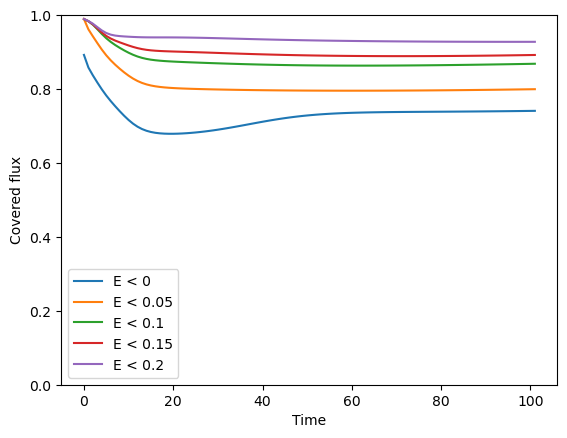

In [ ]:
for e in [0, 0.05, 0.1, 0.15, 0.2]:
    reduced = analyze_reduction_accuracy(graphs, e)
plt.xlabel("Time")
plt.ylabel("Covered flux")
plt.ylim(0, 1)
plt.legend()
# analyze size reduction 


In [ ]:
og, rg = run_reduction(30, 1000, norm(0.4, 0.3), energy_th=0.00, temperature=700)
rates = solve_kinetics(og)
total_rates = rates.sum(axis=1)
relative_rates = rates.apply(lambda x: x / total_rates, axis=0)

In [110]:
print(relative_rates.apply(lambda x: sum([r > 0 for r in x]), axis=1).mean(), relative_rates.apply(lambda x: sum([r > 0.001 for r in x]), axis=1).mean())

965.6274509803922 42.35294117647059


(0.0, 1.0)

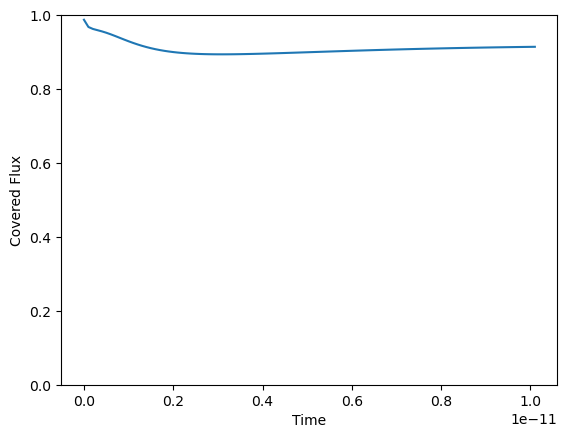

In [111]:
covered_flux = relative_rates[[rxn for rxn in rg.get_reactions()]].sum(axis=1)
plt.plot(covered_flux.index, covered_flux.values)
plt.xlabel("Time")
plt.ylabel("Covered Flux")
plt.ylim(0, 1)

In [ ]:
plt.hist([np.log(r) for r in rates.values() if not r == 0], label="original", alpha=0.7, density=True, bins=50)
reduced_rates = [np.log(rates[r]) for r in rg.get_reactions() if not rates[r] == 0]
plt.hist(reduced_rates, label="reduced", alpha=0.7, density=True, bins=50)
plt.legend()